<a href="https://colab.research.google.com/github/SpringsteinM/deep_learning_tutorial/blob/main/summer_school_1_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training eines Deep Learning Models für Kunst Informationen

In diesem Beispiel definieren wir ein neuronales Netz und optimieren es für die Vorhersage von kunstrelevanten Attributen. 

## Herunterladen des "Painter by Numbers" Kunstdatensatzes

In [1]:
kaggle_key = "2c3bb8a50229a2b78a0c8e2e1867a412" #@param {type:"string"}


In [2]:
%%capture
!pip install open_clip_torch;
!pip install kaggle;
!pip install torchdata
!pip install pytorch-lightning
!pip install torchmetrics
!mkdir ~/.kaggle -p;

In [3]:
import json
from pathlib import Path
kaggle_path = str(Path.home()/".kaggle"/"kaggle.json")
with open(kaggle_path,"w") as f:
  json.dump({"username":"bhaallord","key":kaggle_key},f)
!chmod 600 ~/.kaggle/kaggle.json;

In [4]:
!kaggle competitions download -c painter-by-numbers -f train_1.zip
!kaggle competitions download -c painter-by-numbers -f train_info.csv

train_1.zip: Skipping, found more recently modified local copy (use --force to force download)
train_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
%%capture
!unzip -o train_info.csv.zip

## Definition aller notwendigen Funktionen und Klassen

In [6]:

import csv
import re
import imageio
import torch
import numpy as np
from torchdata.datapipes.iter import FileLister, FileOpener
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from PIL import Image

train_t = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
val_t = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


def preprocess_image(image):
    return val_t(image)

def preprocess_train_image(image):
    return train_t(image)

def read_info(info_path="train_info.csv", data_field="style"):
    data = []
    if data_field == "style":
        data_field = 3
    else:
        data_field = 4
    with open(info_path) as csvfile:
        spamreader = csv.reader(csvfile)
        next(spamreader)
        for line in spamreader:
            data.append((line[0], line[data_field]))
    return data

def generate_class_map(info_path="train_info.csv", data_field="style"):
    data = []
    class_map = {}
    if data_field == "style":
        data_field = 3
    else:
        data_field = 4
    with open(info_path) as csvfile:
        spamreader = csv.reader(csvfile)
        next(spamreader)
        for line in spamreader:
            if line[data_field] not in class_map:
                class_map[line[data_field]] = len(class_map)
    return class_map

def split_data(data, train_size=0.9):
    return torch.utils.data.random_split(data, (int(0.9 * len(data)), len(data) - int(0.9 * len(data))))

def generate_iterator(data_path="train_1.zip", info_path="train_info.csv", data_field="style", set="val"):
    # load meta and split datasets
    data = []
    class_map = {}
    if data_field == "style":
        data_field = 3
    else:
        data_field = 4
    with open(info_path) as csvfile:
        spamreader = csv.reader(csvfile)
        next(spamreader)
        for line in spamreader:
            if line[data_field] not in class_map:
                class_map[line[data_field]] = len(class_map)
            data.append((line[0], line[data_field]))
    # dp = ImageFolder(str(path))
    # model_dataset = WrapDataset(torchvision.datasets.ImageFolder(path))
    train_data, val_data = torch.utils.data.random_split(data, 
      (int(0.9 * len(data)), len(data) - int(0.9 * len(data))), 
      generator=torch.Generator().manual_seed(42))
    train_data = {k: v for k, v in train_data}
    val_data = {k: v for k, v in val_data}
    data = {k: v for k, v in data}
    # building val and train pipe

    dp = FileLister(".", "*.zip")
    dp = FileOpener(dp, mode="b")
    dp = dp.load_from_zip()

    def decode_data(d):
      try:
        filename = d[0].split("/")[-1]
        label = data.get(filename)
        label_id = class_map.get(label)
        return {"filename": filename, "label": label, "label_id": label_id, "image_data": d[1]}
      except:
        return None

    dp = dp.map(decode_data)
    if set=="val":
      dp = dp.filter(lambda d: d["filename"] in val_data)
    elif set=="train":
      dp = dp.filter(lambda d: d["filename"] in train_data)

    def decode_image(d):
      try:
        filename = d["filename"]
        label = d["label"]
        label_id =  d["label_id"]
        image = imageio.imread(d["image_data"])
        if len(image.shape) == 2:
          image = np.expand_dims(image, axis=-1)
        if image.shape[2] != 3:
          image = np.concatenate([image,image,image], axis=-1)
        if image.shape[-1] != 3:
          return None
        return {"filename": filename, "label": label, "label_id": label_id, "image": image}
      except:
        return None

    dp = dp.map(decode_image)

    dp = dp.map(lambda x: {**x, "image": preprocess_image(to_pil_image(x["image"]))})
    
    return dp

def generate_dataloaders(data_path="train_1.zip", info_path="train_info.csv", data_field="style"):
    # load meta and split datasets
    data = []
    class_map = {}
    if data_field == "style":
        data_field = 3
    else:
        data_field = 4
    with open(info_path) as csvfile:
        spamreader = csv.reader(csvfile)
        next(spamreader)
        for line in spamreader:
            if line[data_field] not in class_map:
                class_map[line[data_field]] = len(class_map)
            data.append((line[0], line[data_field]))
    # dp = ImageFolder(str(path))
    # model_dataset = WrapDataset(torchvision.datasets.ImageFolder(path))
    train_data, val_data = torch.utils.data.random_split(data, 
      (int(0.9 * len(data)), len(data) - int(0.9 * len(data))), 
      generator=torch.Generator().manual_seed(42))
    train_data = {k: v for k, v in train_data}
    val_data = {k: v for k, v in val_data}
    data = {k: v for k, v in data}
    # building val and train pipe

    dp = FileLister(".", "*.zip")
    dp = FileOpener(dp, mode="b")
    dp = dp.load_from_zip()
    dp = dp.shuffle(buffer_size=128)


    def decode_data(d):
      try:
        filename = d[0].split("/")[-1]
        label = data.get(filename)
        label_id = class_map.get(label)
        return {"filename": filename, "label": label, "label_id": label_id, "image_data": d[1]}
      except:
        return None

    dp = dp.map(decode_data)
    val_dp = dp.filter(lambda d: d["filename"] in val_data)
    train_dp = dp.filter(lambda d: d["filename"] in train_data)

    def decode_image(d):
      try:
        filename = d["filename"]
        label = d["label"]
        label_id =  d["label_id"]
        image = imageio.imread(d["image_data"])
        if len(image.shape) == 2:
          image = np.expand_dims(image, axis=-1)
        if image.shape[2] != 3:
          image = np.concatenate([image,image,image], axis=-1)
        if image.shape[-1] != 3:
          return None
        return {"filename": filename, "label": label, "label_id": label_id, "image": image}
      except:
        return None

    val_dp = val_dp.map(decode_image)
    train_dp = train_dp.map(decode_image)

    val_dp = val_dp.filter(lambda x: x is not None)
    train_dp = train_dp.filter(lambda x: x is not None)

    train_dp = train_dp.map(lambda x: {**x, "image": preprocess_train_image(to_pil_image(x["image"]))})
    val_dp = val_dp.map(lambda x: {**x, "image": preprocess_image(to_pil_image(x["image"]))})
    
    return DataLoader(train_dp, batch_size=64, num_workers=1), DataLoader(val_dp, batch_size=64, num_workers=1)

def show_image_grid(images, labels=None):
  plt.rcParams['figure.figsize'] = [18, 5]
  image_grid = torchvision.utils.make_grid(images,nrow=4).numpy().transpose((1, 2, 0))

  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image_grid = std * image_grid + mean
  image_grid = np.clip(image_grid, 0, 1)

  plt.imshow(image_grid)
  if labels is not None:
      plt.title(labels)

## Erkundung der vorhandenen Daten

In [7]:
label_type = "style" #@param ["style", "genre"]
seed = 38 #@param {type:"slider", min:0, max:100, step:1}

INFO:pytorch_lightning.utilities.seed:Global seed set to 38


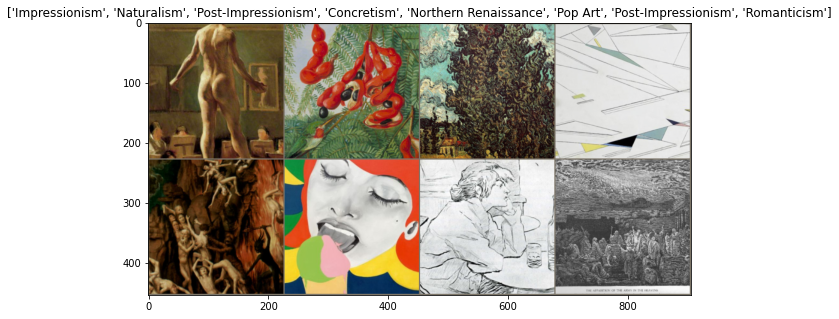

In [8]:

import torchvision
import matplotlib as mpl
import matplotlib.pyplot as plt

import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed)

class_map = generate_class_map(data_field=label_type)
class_map_inv = {v:k for k,v in class_map.items()}

image_generator = iter(generate_iterator(data_field=label_type))
images = []
labels = []
for x in range(8):
  data = next(image_generator)
  images.append(data["image"])
  labels.append(data["label"])
show_image_grid(images, labels)

## Definition der Trainingsfunktion

Diese Funktion übernimmt das Training für uns. Die Bilder und deren Label (Batch) werden aus unserer Datenpipeline geholt und für die Optimierung verwendet.




In [9]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import copy
from IPython import display
from torch import autocast

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, max_iter = 200):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    steps = []
    losses = []
    accuracies = []

    global_step = 0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        dataloaders = {
            'train':train_loader,
            'val':val_loader
        }
        

        # Each epoch has a training and validation phase
        for phase in ['train']:

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            sample_count = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch["image"].to(device)
                labels = batch["label_id"].to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast("cuda"):

                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                sample_count += labels.shape[0]

                steps.append(global_step)
                losses.append((loss.item()))
                accuracies.append((torch.sum(preds == labels.data)/inputs.size(0)).cpu().detach().numpy())

                if phase == 'train':
                  # print(f'Epoch {epoch}/{num_epochs - 1} Step {global_step} Phase {phase}')
                  fig, axs = plt.subplots(2, 1)
                  axs[0].plot(steps,losses, color="r") 
                  axs[0].set_xlabel('time')
                  axs[0].set_ylabel('loss')
                  axs[1].plot(steps,accuracies,  color="b")    
                  axs[1].set_xlabel('time')
                  axs[1].set_ylabel('accuracy')
                  display.clear_output(wait=True)
                  display.display(plt.gcf())


                  global_step+=1
                
                if max_iter and global_step > max_iter:
                  return 


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sample_count
            epoch_acc = running_corrects.double() / sample_count

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    display.clear_output(wait=True)
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(steps,losses, color="r") 
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('loss')
    axs[1].plot(steps,accuracies,  color="b")    
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('accuracy')
    return model

## Definition aller notwendigen Komponenten

Hier definieren wir alle wichtigen Komponenten unseres Trainingsprozesses, die Folgendes umfassen:
- Ein neuronales Modell, das ein Bild als Eingabe erhält und die Klassenwahrscheinlichkeit für jede einzelne Klasse liefert
-  Ein Optimierungsverfahren, das festlegt, wie die Differenzen zwischen der Vorhersage und dem Ziel verringert werden sollen
- Ein Optimierungsziel, das definiert, was wir zu erreichen versuchen
- (optional) Eine Lernrate, die bestimmt, wie schnell wir etwas lernen



In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to num classes.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_map))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Evaluierung des neuen Modells


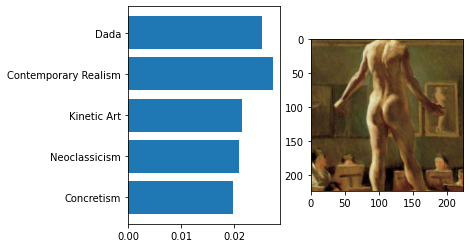

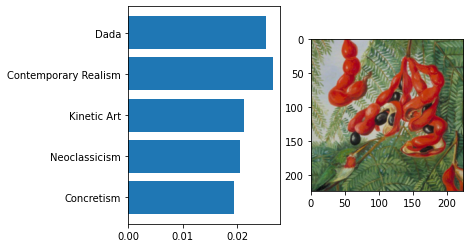

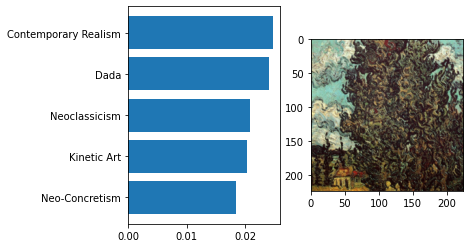

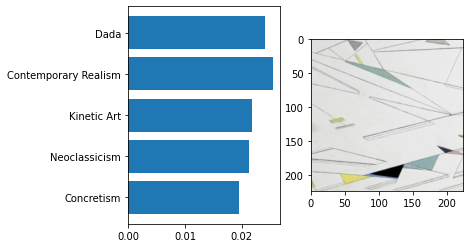

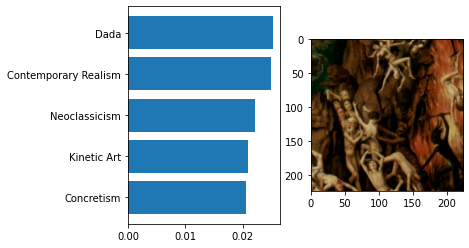

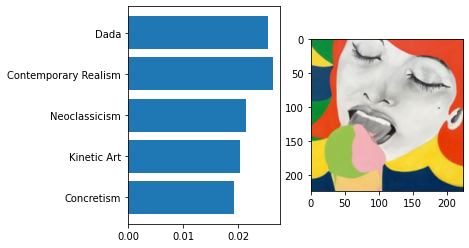

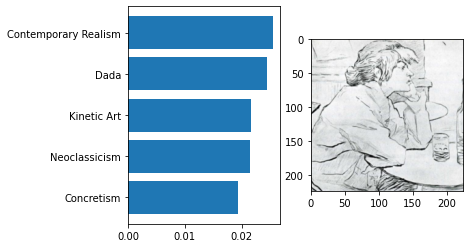

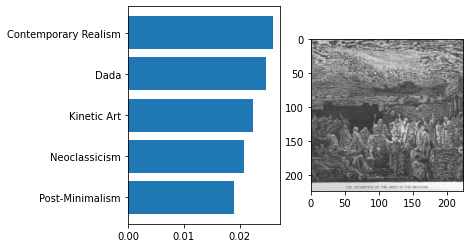

In [11]:
image_generator = iter(generate_iterator(data_field=label_type))
for x in range(8):
  data = next(image_generator)
  prediction = torch.nn.functional.softmax(model_ft(data["image"].to(device).unsqueeze(0)), dim=-1).squeeze()
  prediction = prediction.cpu().detach().numpy()
  top_5 = np.argpartition(prediction, -5)[-5:]

  
  labels = [class_map_inv[x] for x in top_5]
  prob = prediction[top_5]

  image = data["image"].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  fig, axs = plt.subplots(1, 2)
  axs[0].barh(labels, prob)
  axs[1].imshow(image)
  

## Training des neuen Modells

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


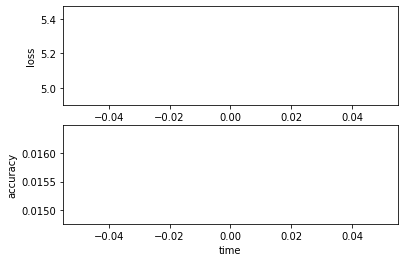

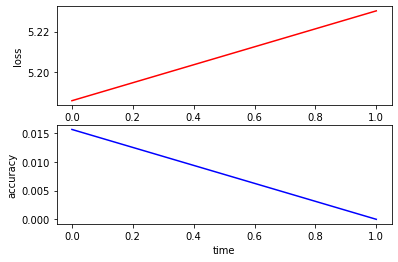

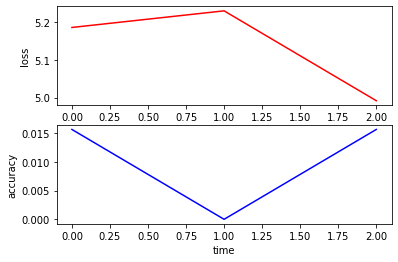

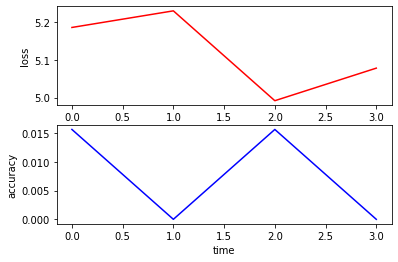

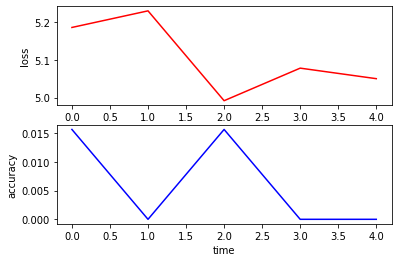

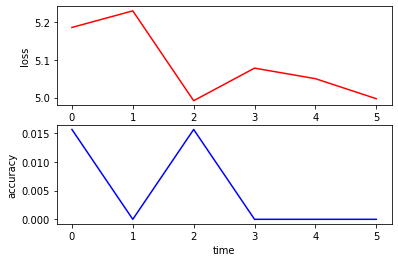

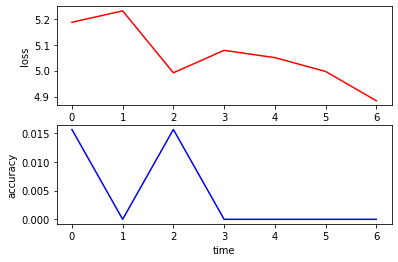

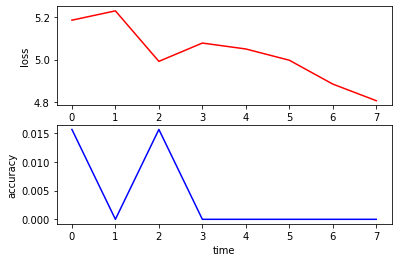

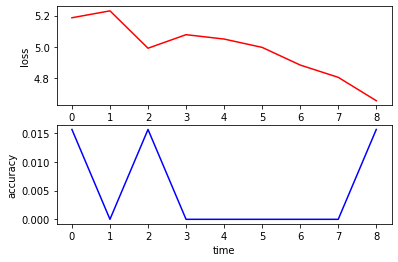

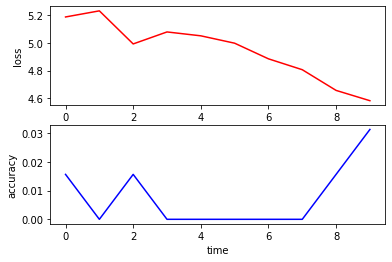

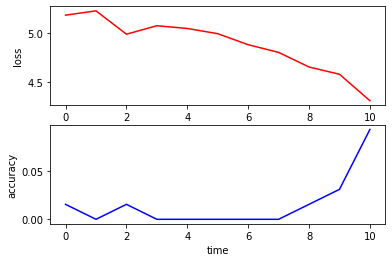

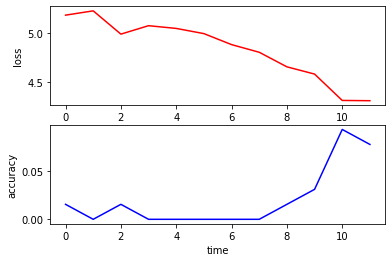

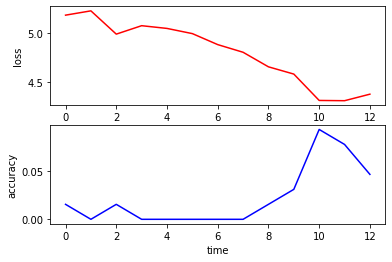

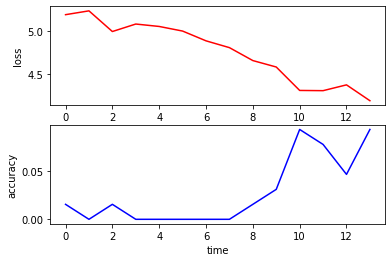

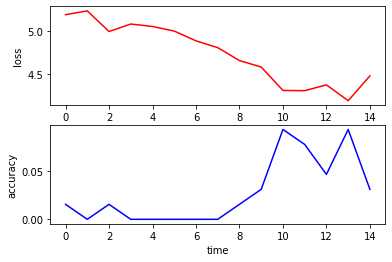

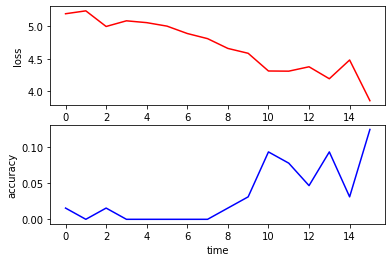

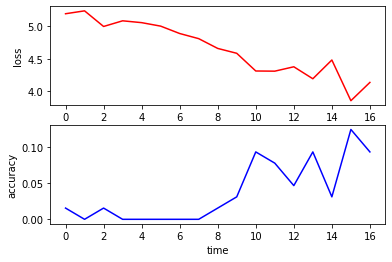

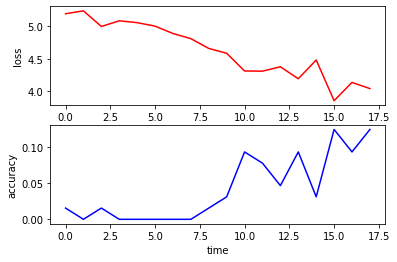

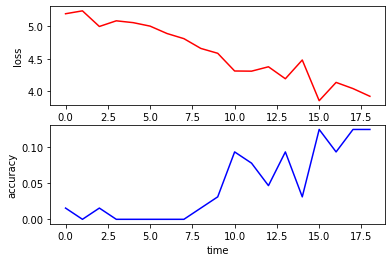

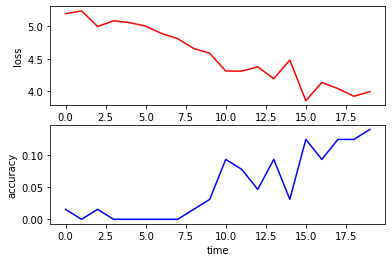

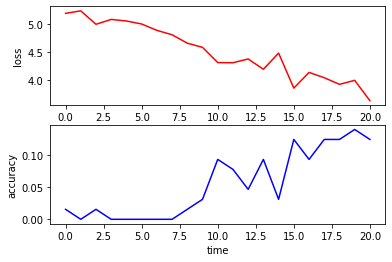

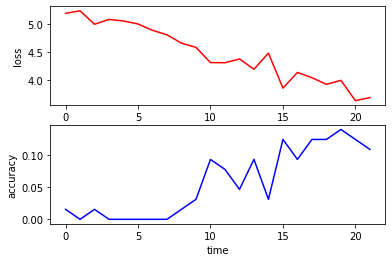

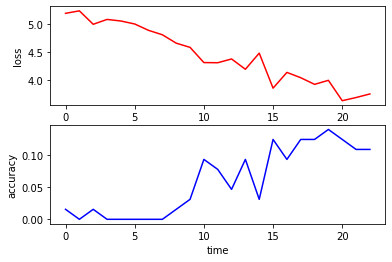

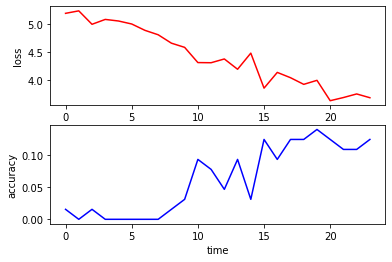

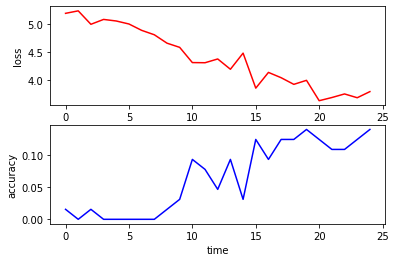

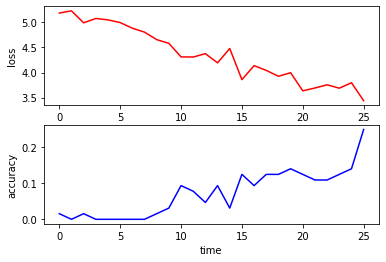

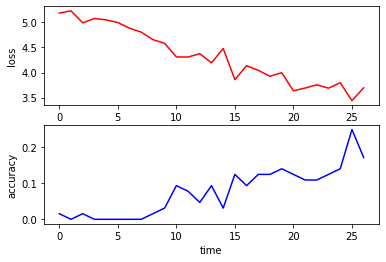

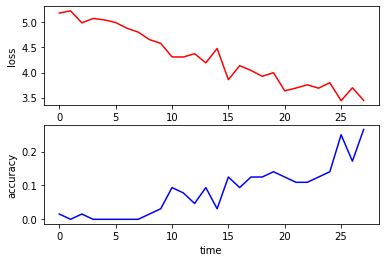

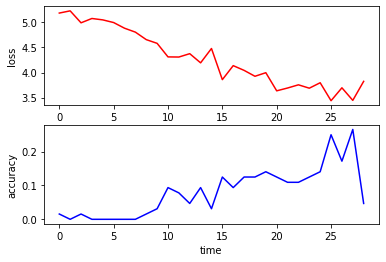

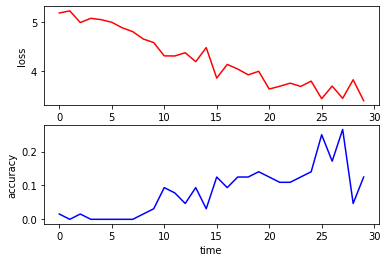

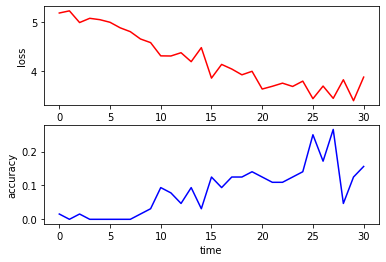

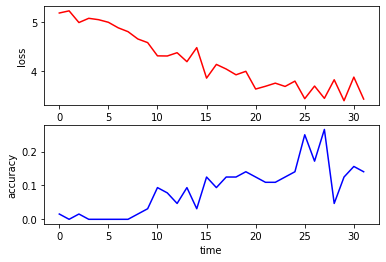

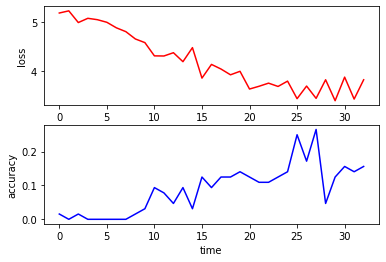

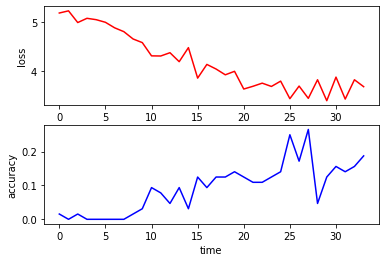

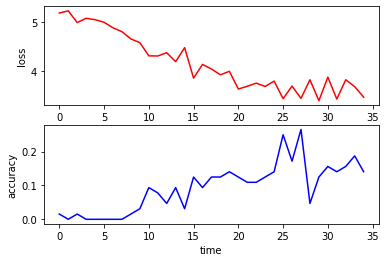

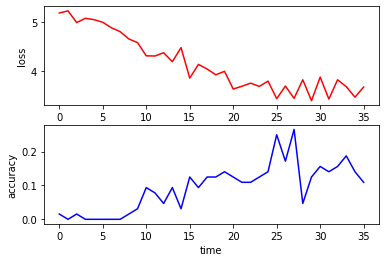

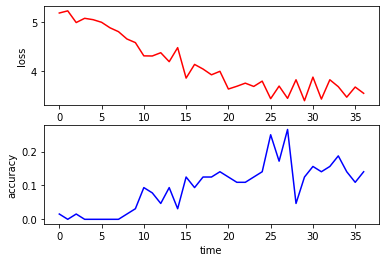

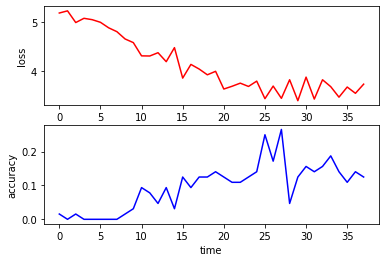

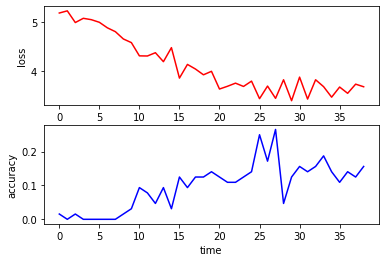

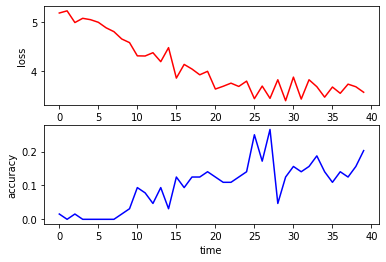

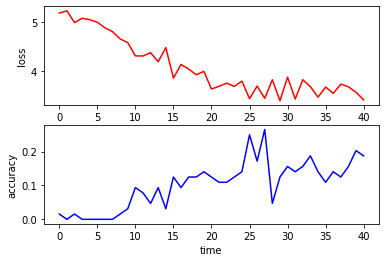

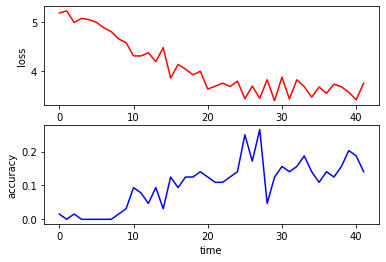

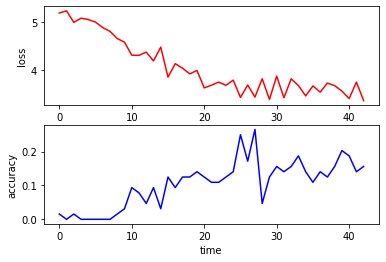

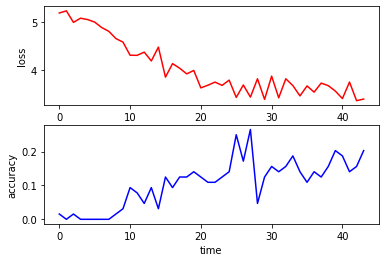

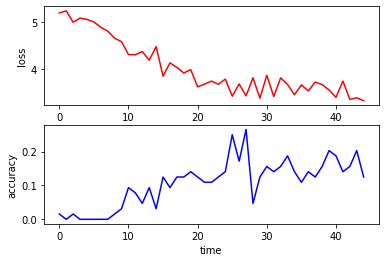

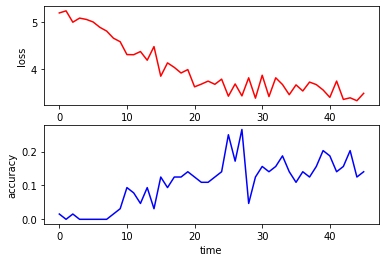

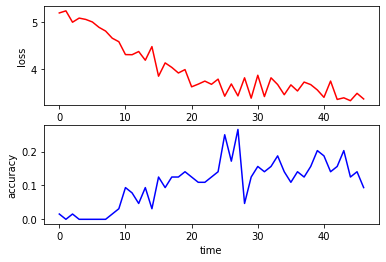

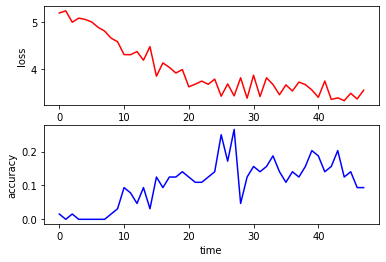

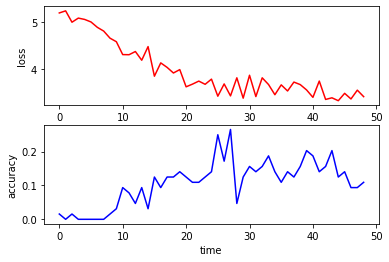

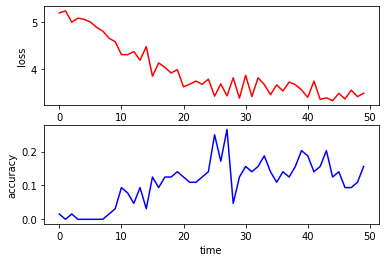

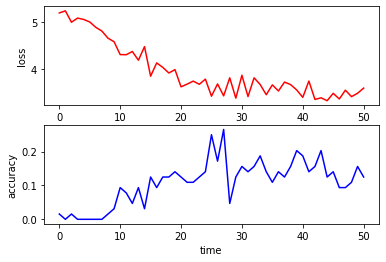

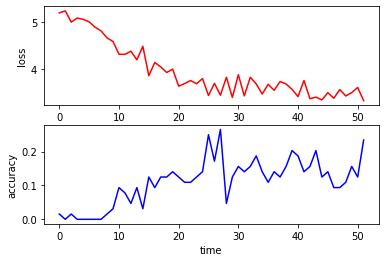

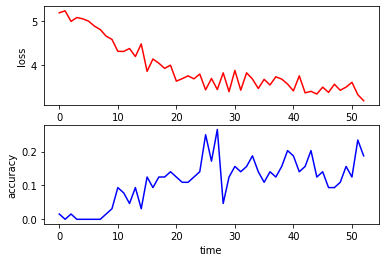

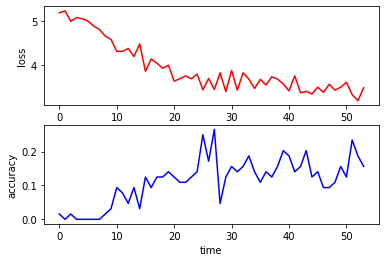

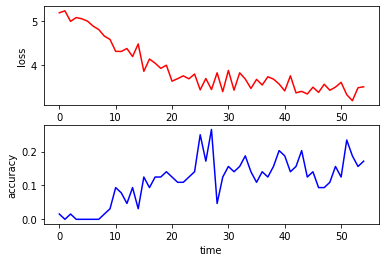

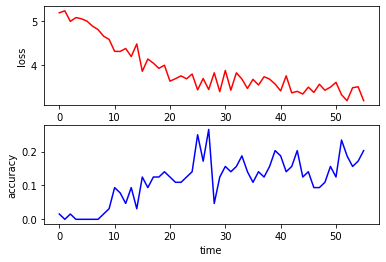

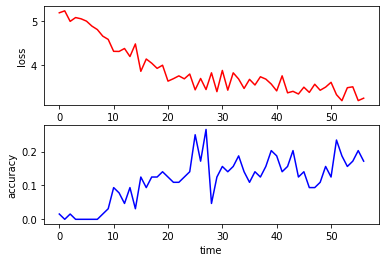

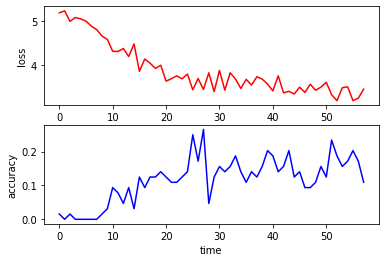

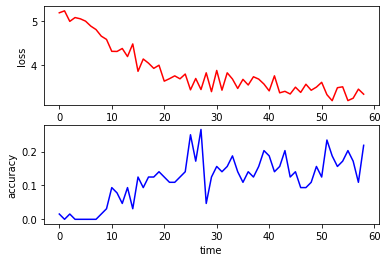

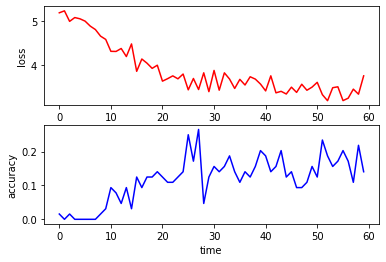

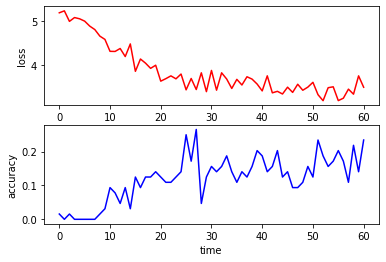

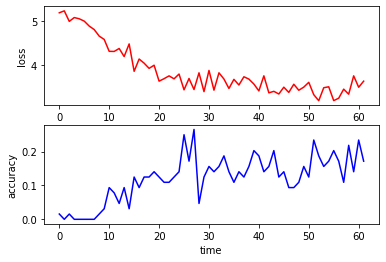

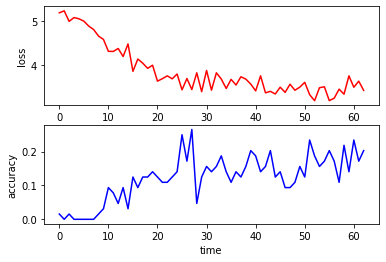

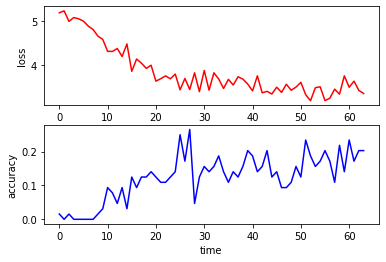

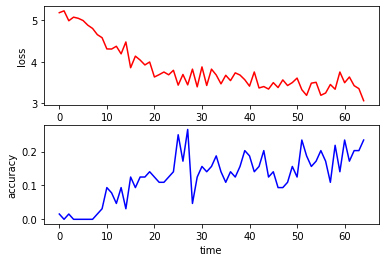

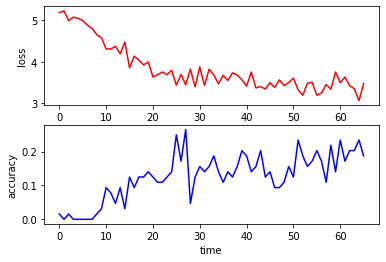

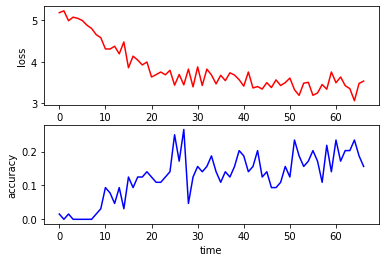

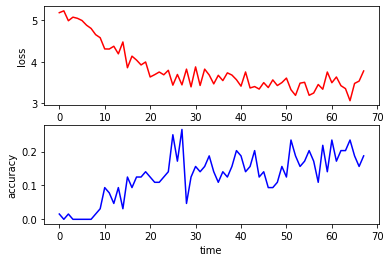

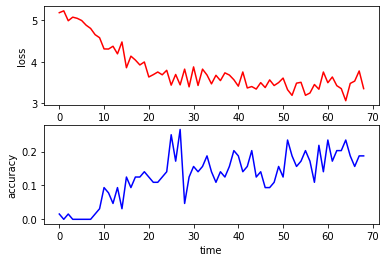

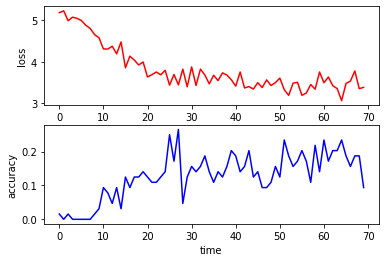

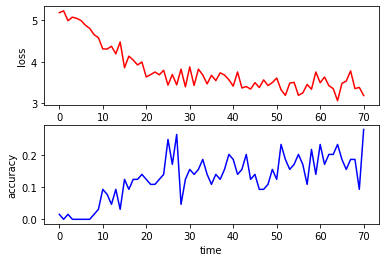

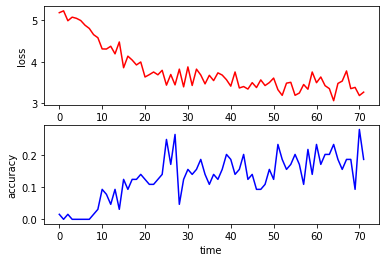

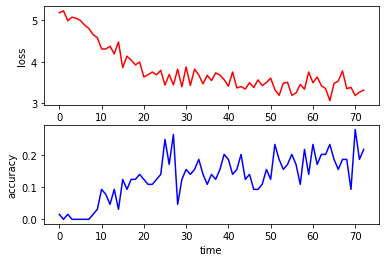

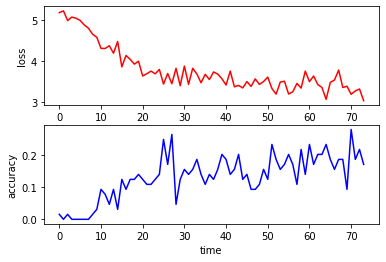

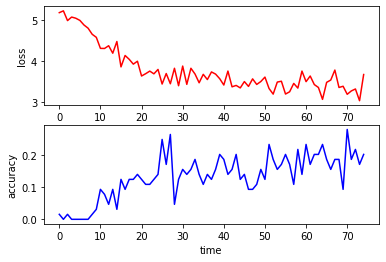

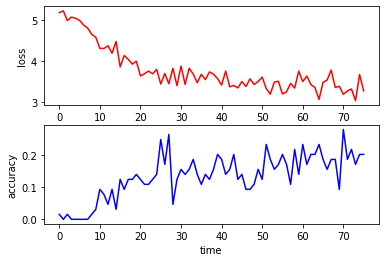

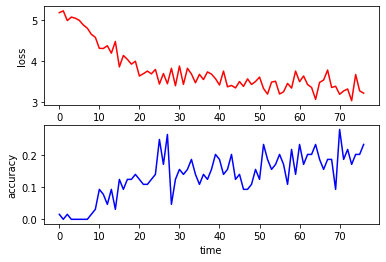

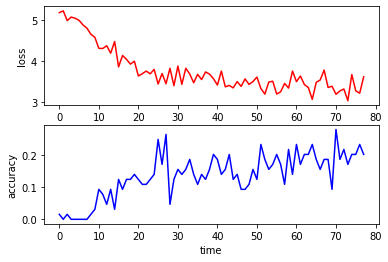

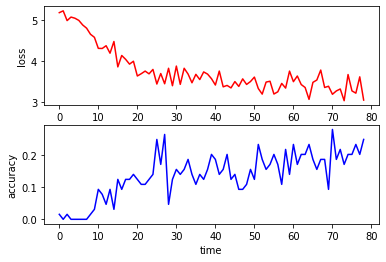

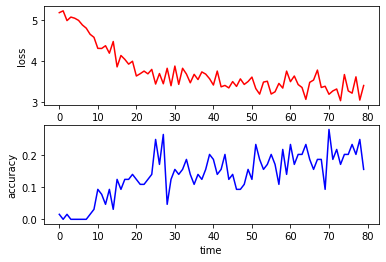

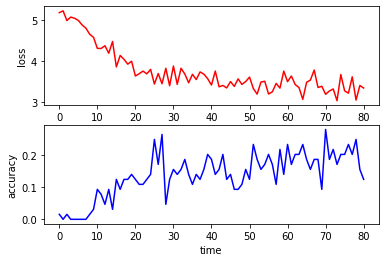

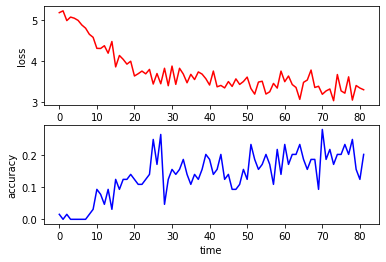

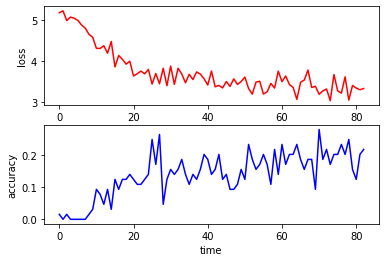

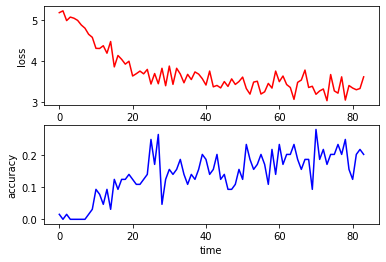

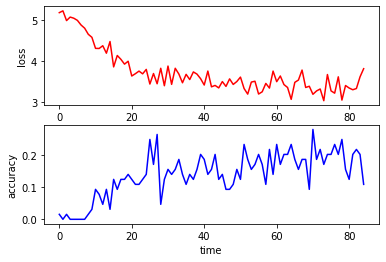

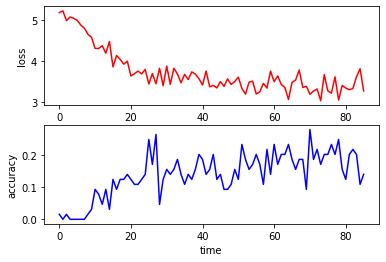

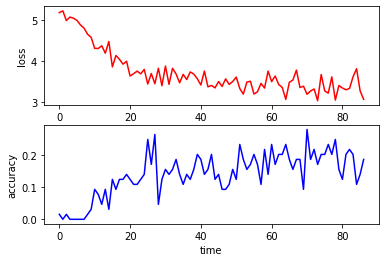

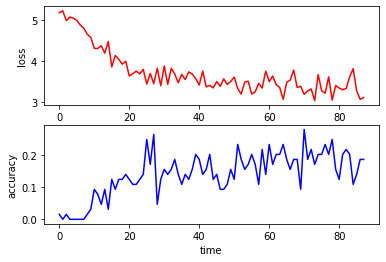

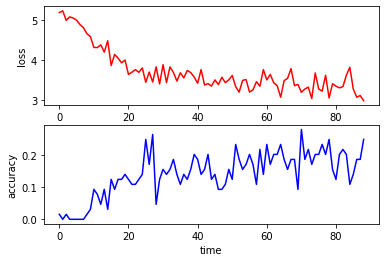

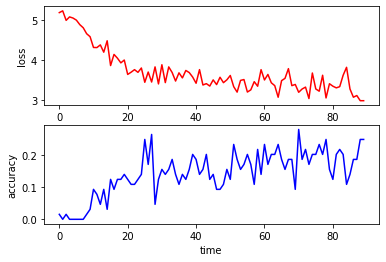

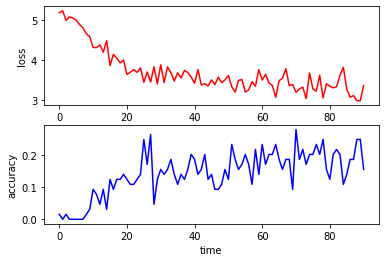

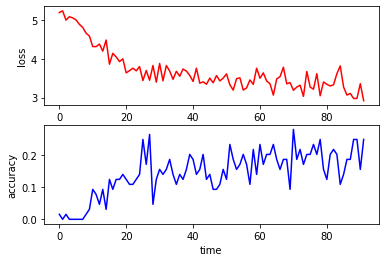

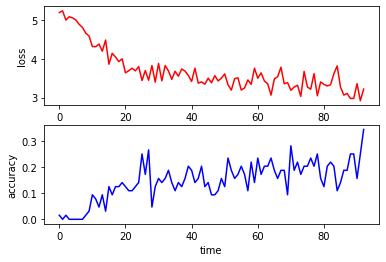

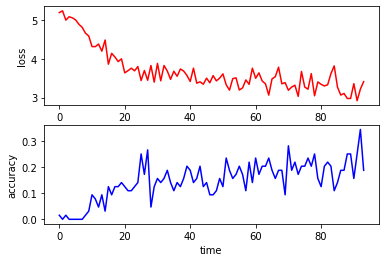

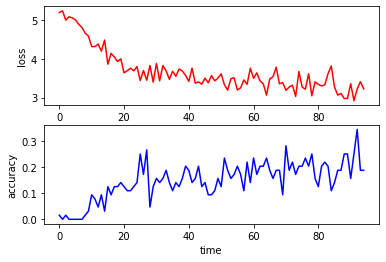

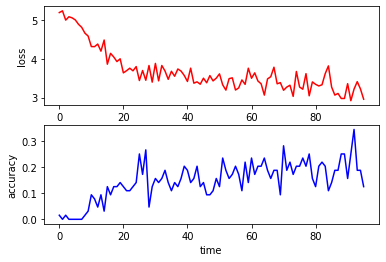

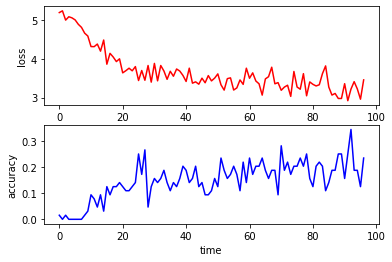

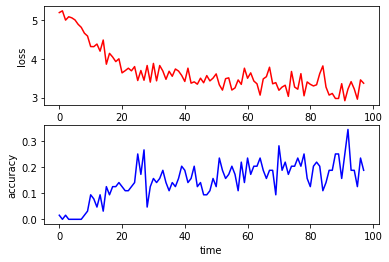

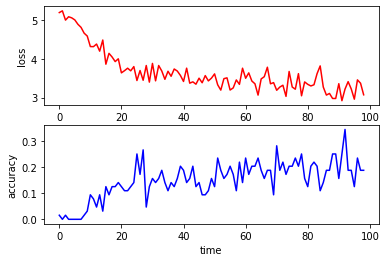

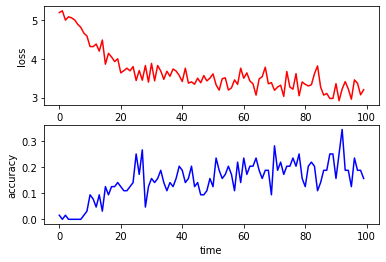

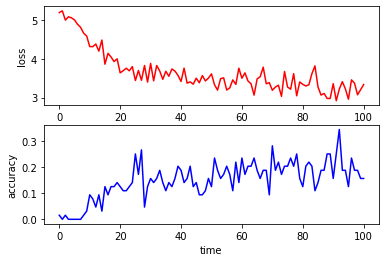

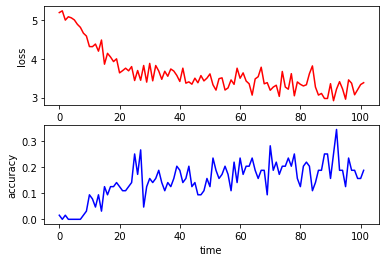

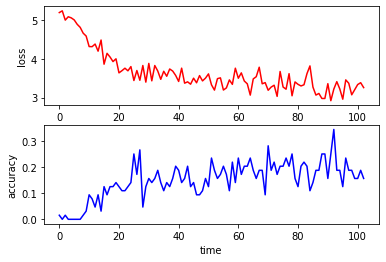

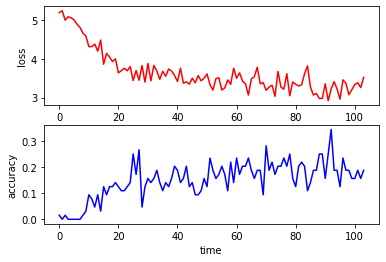

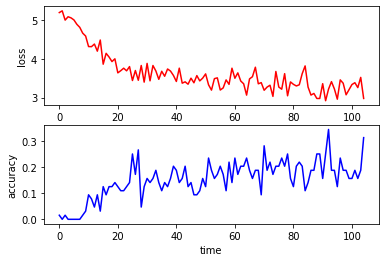

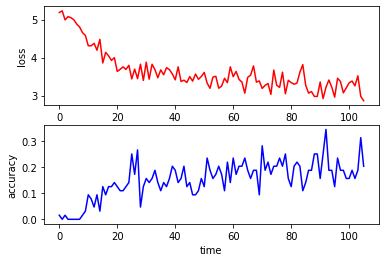

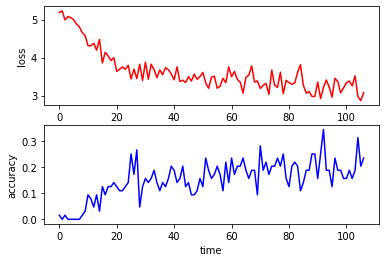

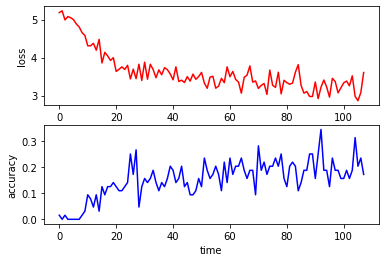

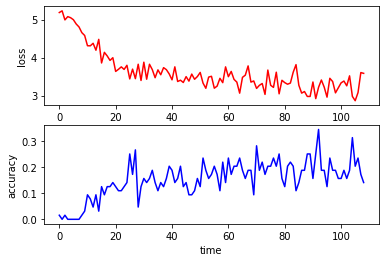

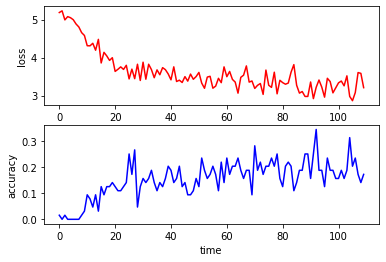

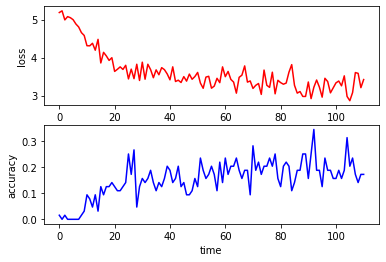

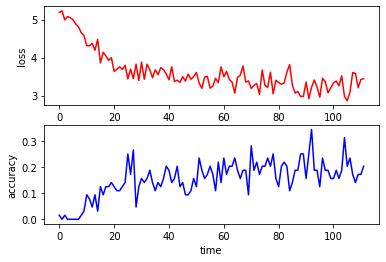

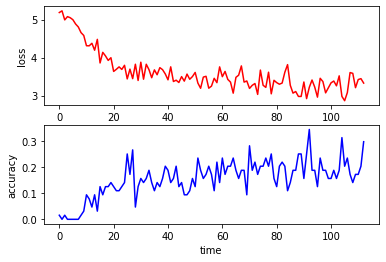

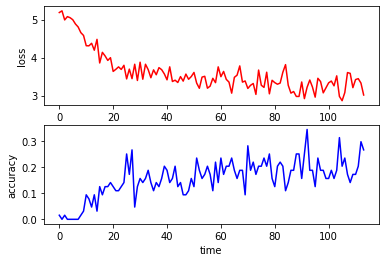

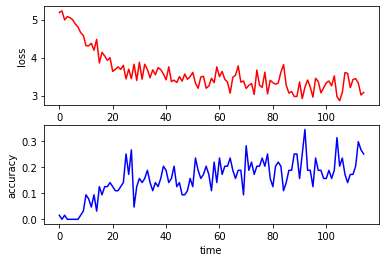

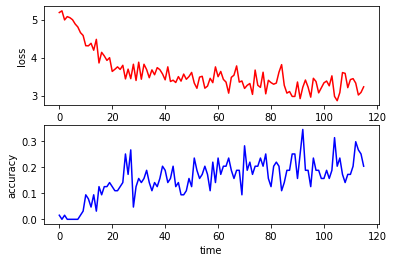

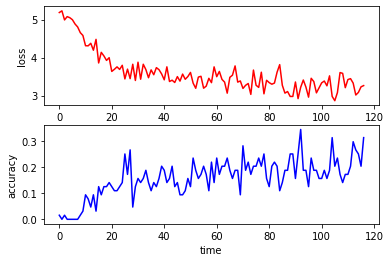

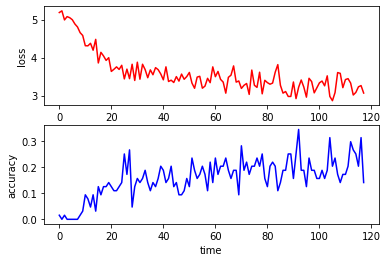

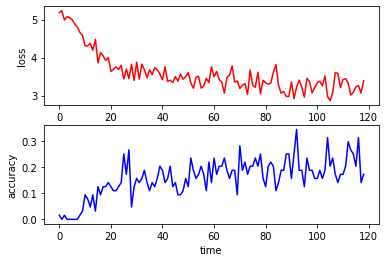

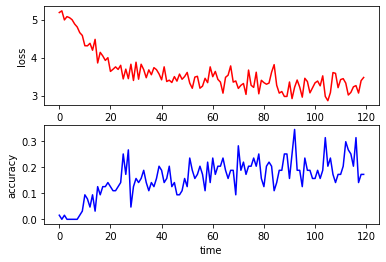

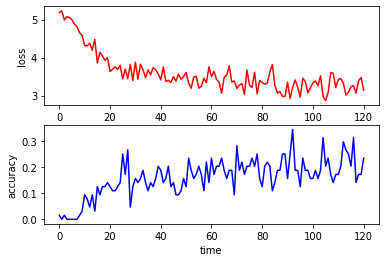

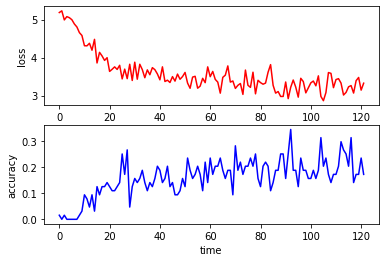

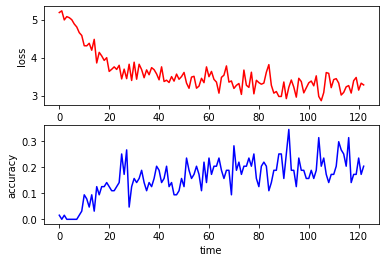

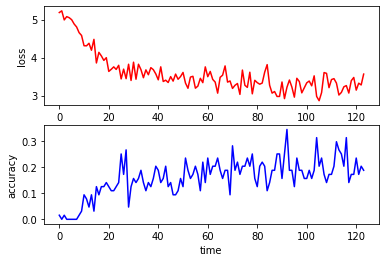

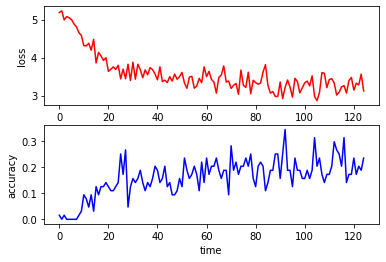

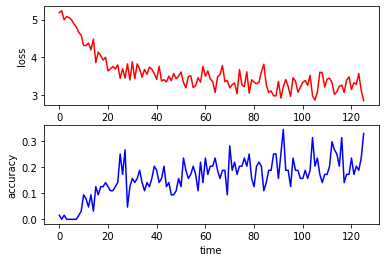

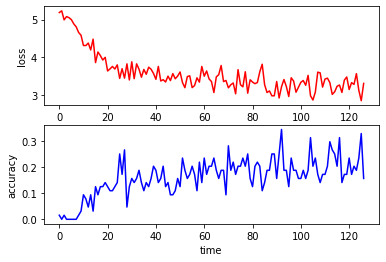

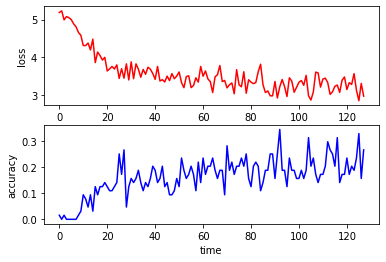

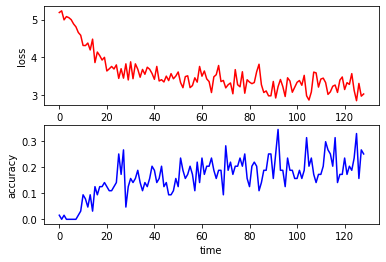

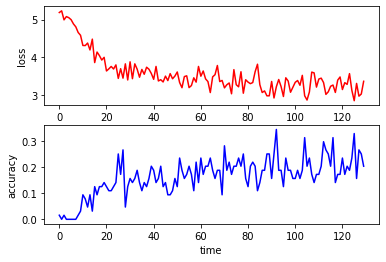

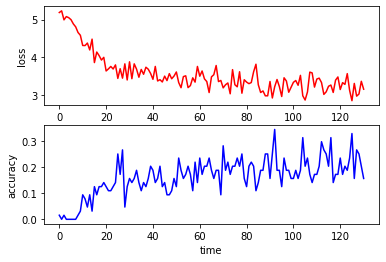

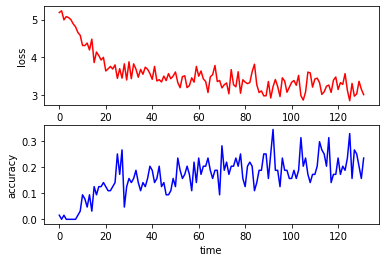

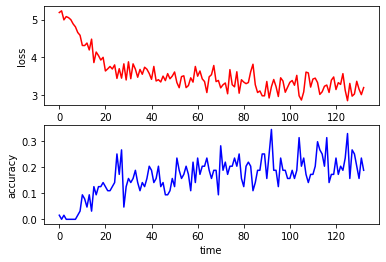

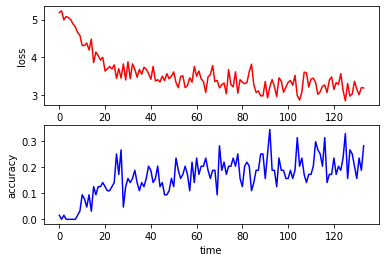

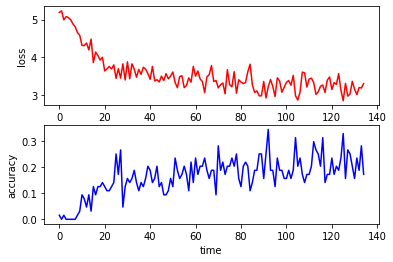

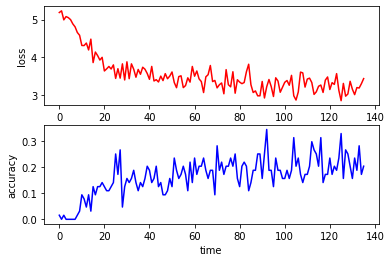

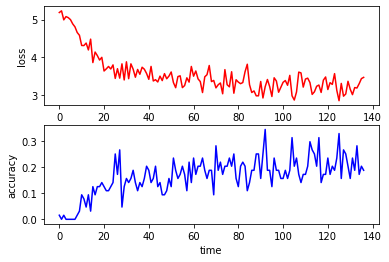

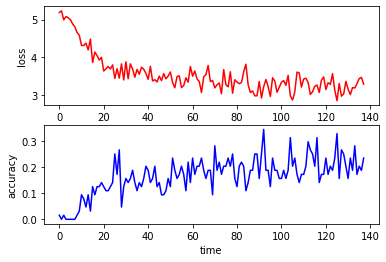

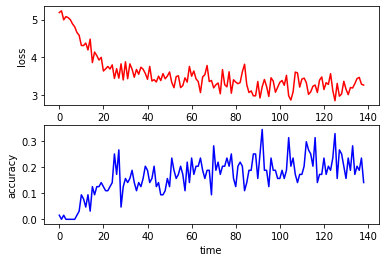

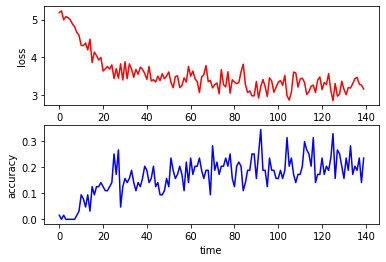

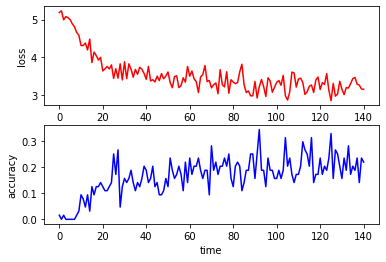

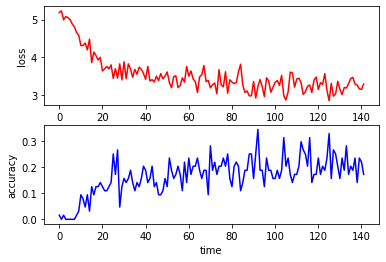

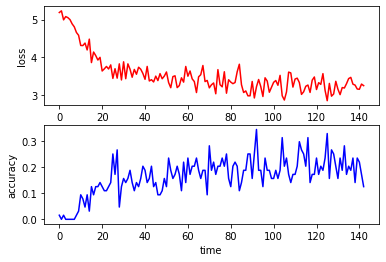

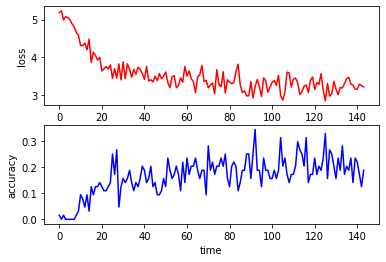

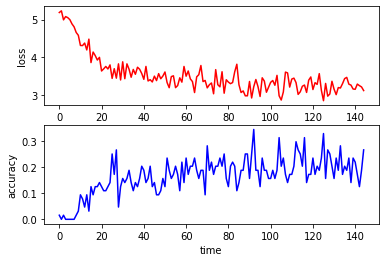

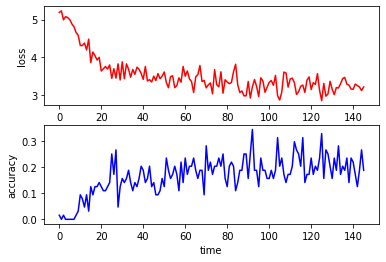

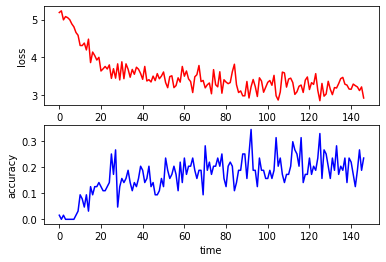

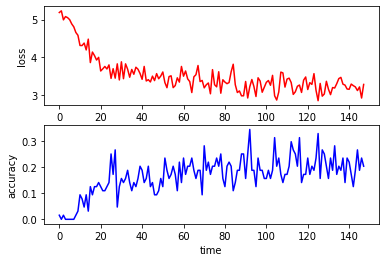

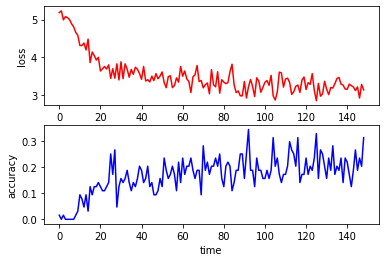

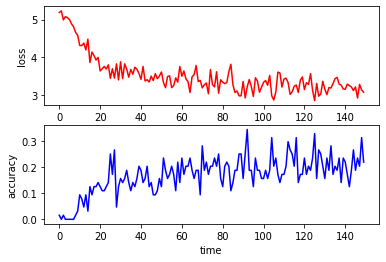

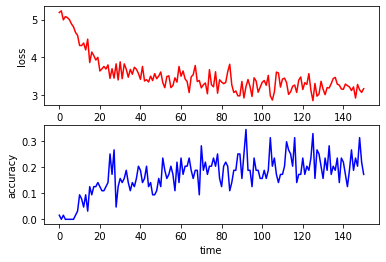

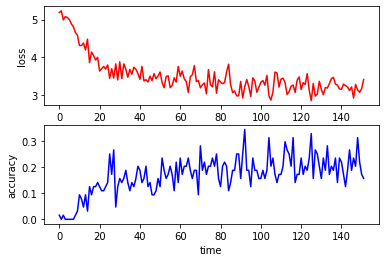

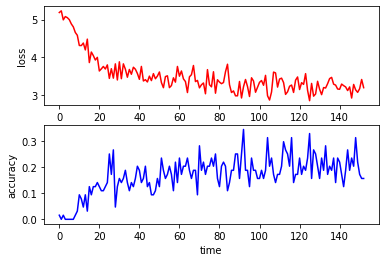

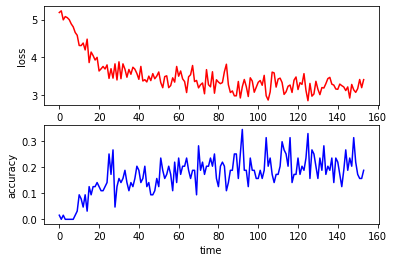

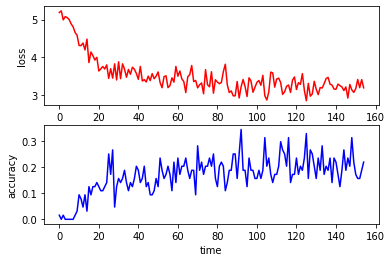

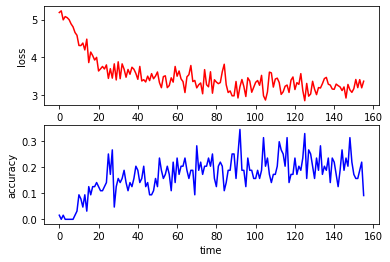

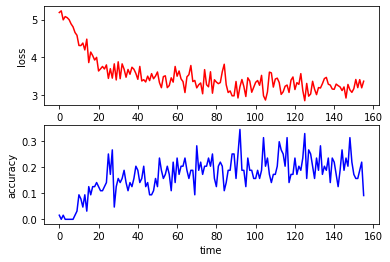

In [12]:
train_loader, val_loader = generate_dataloaders(data_field=label_type)
trained_model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,train_loader, val_loader, num_epochs=1)

## Evaluierung des trainierten Modells

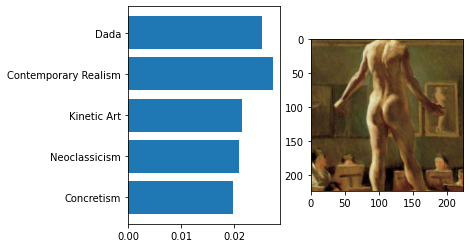

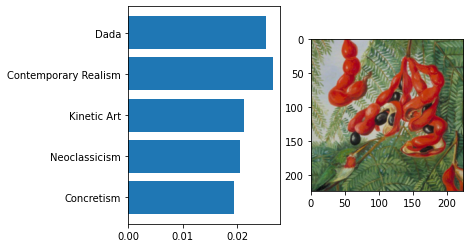

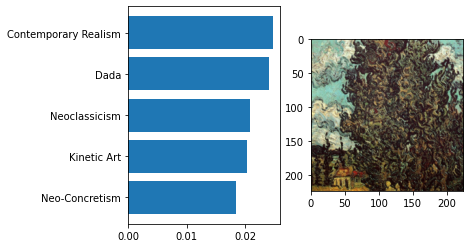

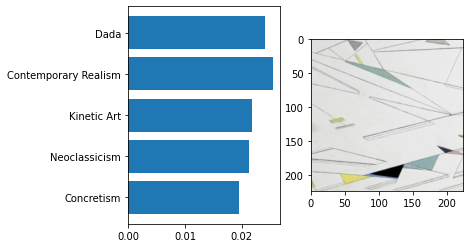

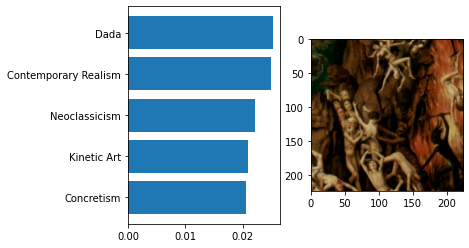

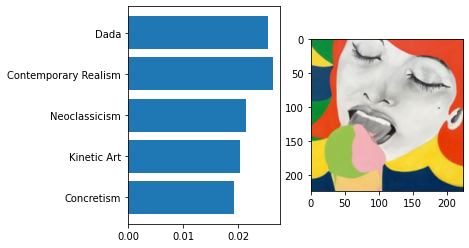

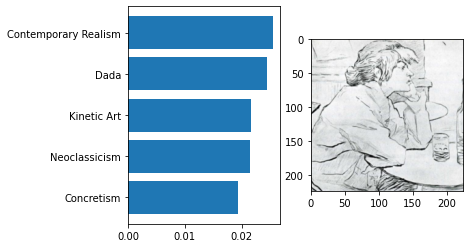

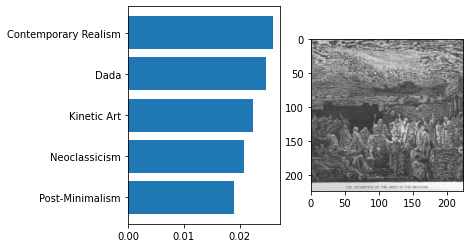

In [13]:
image_generator = iter(generate_iterator(data_field=label_type))
for x in range(8):
  data = next(image_generator)
  prediction = torch.nn.functional.softmax(trained_model_ft(data["image"].to(device).unsqueeze(0)), dim=-1).squeeze()
  prediction = prediction.cpu().detach().numpy()
  top_5 = np.argpartition(prediction, -5)[-5:]

  
  labels = [class_map_inv[x] for x in top_5]
  prob = prediction[top_5]

  image = data["image"].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  fig, axs = plt.subplots(1, 2)
  axs[1].imshow(image)
  axs[0].barh(labels, prob)

In [14]:
from torchmetrics import ConfusionMatrix

def eval(model,  val_loader, num_classes=2):

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    sample_count = 0

    confmat = ConfusionMatrix(num_classes=num_classes)
    # Iterate over data.
    for batch in val_loader:
        inputs = batch["image"].to(device)
        labels = batch["label_id"].to(device)


        with autocast("cuda"):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confmat(preds.cpu(), labels.cpu())
        
        # statistics
        running_corrects += torch.sum(preds == labels.data)
        sample_count += labels.shape[0]


        epoch_acc = running_corrects.double() / sample_count

    
    return confmat.compute(), epoch_acc
  
conf_matrix, acc = eval(trained_model_ft, val_loader, len(class_map))
print(f"Test ACC {acc}")

Test ACC 0.0018484288354898336


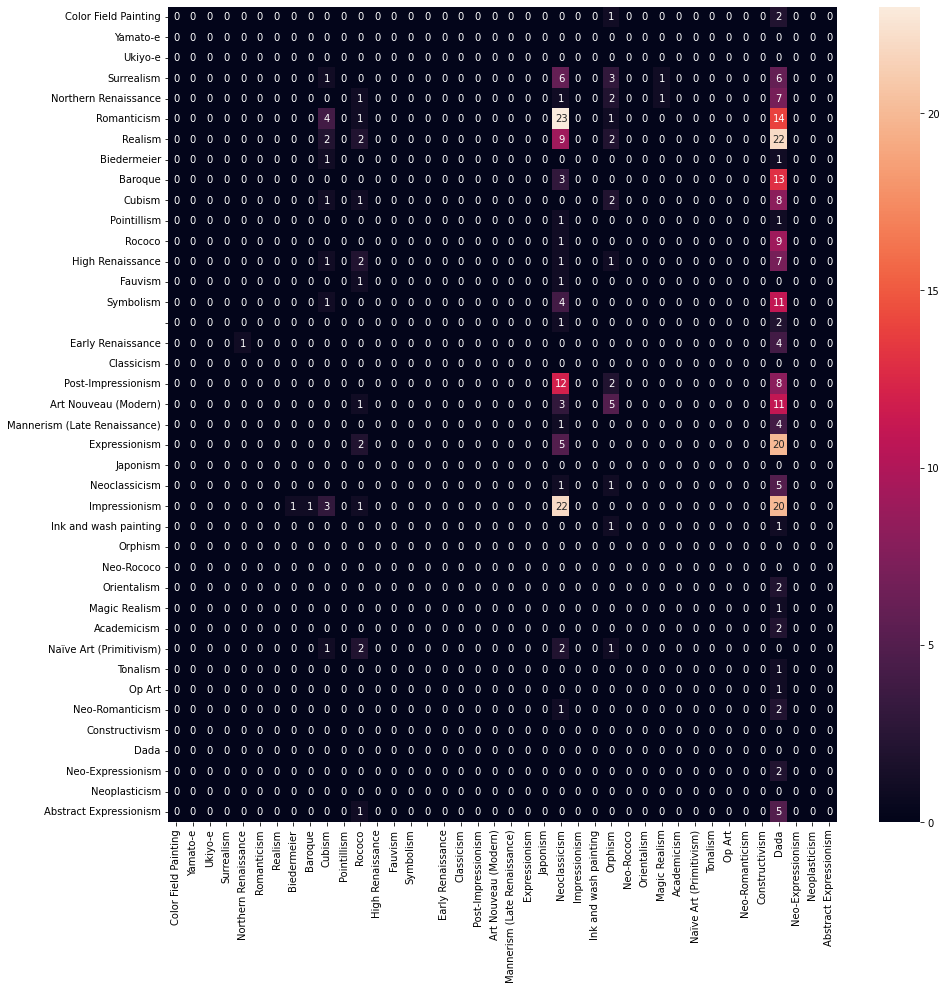

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(conf_matrix.numpy()[:40,:40], index = [i for i in class_map.keys()][:40],
                  columns = [i for i in class_map.keys()][:40])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)

## Jetzt können wir das Modell mit unseren eigenen Daten validieren

In [16]:
from google.colab import files
uploaded = files.upload()


Saving avatar.png to avatar.png


(128, 128, 3)


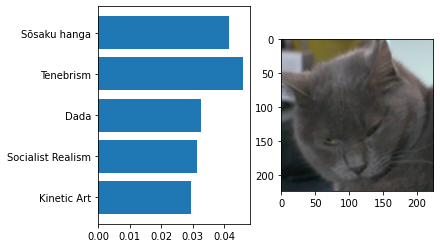

In [17]:
for k, v in uploaded.items():
  print(imageio.imread(v)[...,0:3].shape)
  image = preprocess_image(to_pil_image(imageio.imread(v)[...,0:3]))
  prediction = torch.nn.functional.softmax(trained_model_ft(image.to(device).unsqueeze(0)), dim=-1).squeeze()
  prediction = prediction.cpu().detach().numpy()
  top_5 = np.argpartition(prediction, -5)[-5:]

  
  labels = [class_map_inv[x] for x in top_5]
  prob = prediction[top_5]

  image = image.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  fig, axs = plt.subplots(1, 2)
  axs[1].imshow(image)
  axs[0].barh(labels, prob)